In [ ]:
#Bayesian Optimization using Gaussian Processes for Hyperparameter Tuning with noisy experimental data.

import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch import kernels, means, likelihoods
from gpytorch.priors import LogNormalPrior
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms import Standardize, Normalize
from botorch.utils.transforms import unnormalize

from pyDOE3 import lhs


import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline
%load_ext autoreload
%autoreload 2


seed= 0 # keeps inputs generated from lhs consistent across runs (also feeds into numpy)
# might want to set tensor random seed


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
# define ititial sample number
initial_sample = 24

# Define bounds for the parameters 
# careful with this as there's no checks to ensure bounds are realistic
# or that lower bounds is less than upper bounds.
bounds = torch.tensor([
    [6.0, 20.0],  # Lower bounds ph, temp
    [8.0, 40.0]   # Upper bounds ph, temp
], dtype=torch.double)

dim = bounds.shape[1]# Extracts number of dimensions from bounds variable
noise_level = 0.1 # this var is used in the fixed noise gp model to denote 10% noise in experimental output. It is also used in the objective function to add noise to the function


# standard Latin hypercube using maximin criterion (converts to tensor)
lhs_design = torch.tensor(
            lhs(n = dim, samples = initial_sample, criterion = 'maximin', random_state=seed), 
        dtype=torch.double
        )

# flexibly set the bounds using 'bounds' variable (allowing for dimensional scale-up)
scaled_lhs_design = bounds[0] + (bounds[1]-bounds[0])*lhs_design

#print(scaled_lhs_design)

# This is the black box function we want to converge to. Here we use a simple function so we can generate train_Y from initial dataset and also validate the convergence of the BO model
def objective_function(X, pHopt =7 , temp_opt =35, a = 100, b = 1, c = 1, noise_level = noise_level, seed = None):
    """
    Simulates a 2D Gaussian-like response surface with controllable noise.

    Parameters:
    - X: input tensor of shape [n, 2], columns are [pH, temp]
    - pHopt, temp_opt: optimal pH and temperature
    - a: peak value (must be high enough to keep output positive)
    - b, c: curvature coefficients (bigger = narrower peak)
    - noise_level: fraction of y to scale the noise (e.g., 0.1 = 10%)

    Returns:
    - y: simulated noisy response values
    """
    if seed is not None:
        torch.manual_seed(seed) # set for reproducibility
    pH, temp = X[:, 0], X[:, 1]
    y = a-b*(pH-pHopt)**2 - c*(temp-temp_opt)**2
    noise = noise_level * y * torch.randn_like(y)
    return y + noise
'''
# generates initial sample using latinhypercube
g=torch.Generator().manual_seed(42) # ensure's results are same each time
train_X = maximin_lhs(initial_sample, bounds, generator=g) # this will be consistent as we set the seed at beginning
'''
# above is broken, below is temp fix
train_X = scaled_lhs_design
# generates solution for initial sample using objective function
train_Y= objective_function(train_X, seed=seed)
train_Y = train_Y.unsqueeze(-1) # reshape to (n, 1) (from (n,))



#print(train_X, train_Y)

In [157]:
#Matern model  (dim is a variable extracted from bounds and denotes number of input dimensions)
class GPModel(SingleTaskGP):
    def __init__(self, train_X, train_Y, fixed_noise=False, noise_level=noise_level,
                 lengthscale_prior=None, outputscale_prior=None):
        
        if fixed_noise: # we can fix the noise in the y output which will allow the model to converge faster assuming amount of data is quite minimal
            print(f"Training with FIXED noise: {noise_level*100:.1f}% of mean output.")
            noise_variance = (noise_level * train_Y.mean()).pow(2)
            train_Yvar = torch.full_like(train_Y, noise_variance)
            likelihood = None # SingleTaskGP handles internally
            super().__init__(
                train_X, train_Y, train_Yvar=train_Yvar, likelihood=likelihood,
                outcome_transform=Standardize(m=1),
                input_transform=Normalize(d=dim)
            )
        else:
            print("Training with LEARNABLE noise (Gaussian Likelihood).")
            likelihood = likelihoods.GaussianLikelihood() # in this case noise is not fixed and we will use Gaussian assumptions to learn the noise
            super().__init__(
                train_X, train_Y, likelihood=likelihood,
                outcome_transform = Standardize(m=1),
                input_transform=Normalize(d=dim) 
            )
        self.mean_module = means.ConstantMean() # Mean function

        # matern kernel with ARD (lengthscale for each input dimension is assumed different)
        matern_kernel = kernels.MaternKernel(nu=5/2, ard_num_dims=dim)
        if lengthscale_prior is not None:
            matern_kernel.lengthscale_prior = lengthscale_prior
        
        self.covar_module = kernels.ScaleKernel(base_kernel=matern_kernel, outputscale_prior=outputscale_prior)

def train_GP_model(train_X, train_Y, fixed_noise = False, noise_level =noise_level, lengthscale_prior=None, outputscale_prior=None): 
    model = GPModel(train_X, train_Y, fixed_noise=fixed_noise, noise_level =noise_level, lengthscale_prior=lengthscale_prior, outputscale_prior=outputscale_prior)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model, mll

Below, train_GP_model, is now designed to return model, mll, so YOU need to fix it (example is in
last line 'model_prior, _' so that it unpacks both) Or else it will cause problems later.

In [143]:
# Train with fixed noise (10%)
model_fixed = train_GP_model(train_X, train_Y, fixed_noise=True, noise_level=noise_level)

# Train with learned noise
model_learn = train_GP_model(train_X, train_Y, fixed_noise=False)

# We can also train model with priors
length_scale_prior = LogNormalPrior(0.0, 0.5) # deafult argument values; controls how quickly function varies (small=wiggly, large=smooth)
output_scale_prior = LogNormalPrior(0.0, 1.0) # default argument values; controls vertical scale of y (large = large variance, small = flatter function)
model_prior, _ = train_GP_model(train_X, train_Y, fixed_noise=False, lengthscale_prior=length_scale_prior, outputscale_prior=output_scale_prior)

Training with FIXED noise: 10.0% of mean output.
Training with LEARNABLE noise (Gaussian Likelihood).
Training with LEARNABLE noise (Gaussian Likelihood).


In [148]:
from botorch.acquisition import UpperConfidenceBound, LogExpectedImprovement, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.acquisition.monte_carlo import qExpectedImprovement, qUpperConfidenceBound, qProbabilityOfImprovement
from botorch.acquisition.logei import qLogNoisyExpectedImprovement

In [ ]:
num_restarts = 5 # default
batch_initial_condittions = (num_restarts=num_restarts, train_X.unsqueeze(1), bounds.shape[1])

#the above is where you stopped... it's still wrong. keep working on this

normalized_bounds = torch.stack([torch.zeros(bounds.shape[1], dtype=bounds.dtype), 
                                 torch.ones(bounds.shape[1], dtype=bounds.dtype)
                                ])
n_iterations = 3

for iteration in range(n_iterations):
    # train model
    model, mll = train_GP_model(train_X, train_Y, fixed_noise=False)

    # Define the acquisition function (UCB, EI, PI)
    acq_func = LogExpectedImprovement(model=model, best_f=train_Y.max(), maximize=True) # maximize=True for maximization problem
    #acq_func = UpperConfidenceBound(model=model, beta=0.1) # UCB
    #acq_func = ProbabilityOfImprovement(model=model, best_f=train_Y.max(), maximize=True) # PI
    #acq_func = qExpectedImprovement(model=model, best_f=train_Y.max(), maximize=True) # qEI
    #acq_func = qUpperConfidenceBound(model=model, beta=0.1) # qUCB
    #acq_func = qProbabilityOfImprovement(model=model, best_f=train_Y.max(), maximize=True) # qPI
    #acq_func = qLogNoisyExpectedImprovement(model=model, best_f=train_Y.max(), maximize=True) # qLogEI
    #acq_func = qLogNoisyExpectedImprovement(model=model, best_f=train_Y.max(), maximize=True, noise_level=noise_level) # qLogEI with noise level
    #acq_func = qLogNoisyExpectedImprovement(model=model, best_f=train_Y.max(), maximize=True, noise_level=noise_level, num_samples=1000) # qLogEI with noise level and num_samples
    #acq_func = qLogNoisyExpectedImprovement(model=model, best_f=train_Y.max(), maximize=True, noise_level=noise_level, num_samples=1000, num_fantasies=5) # qLogEI with noise level and num_samples and num_fantasies
    #acq_func = qLogNoisyExpectedImprovement(model=model, best_f=train_Y.max(), maximize=True, noise_level=noise_level, num_samples=1000, num_fantasies=5, num_restarts=10) # qLogEI with noise level and num_samples and num_fantasies and num_restarts
    #acq_func = qLogNoisyExpectedImprovement(model=model, best_f=train_Y.max(), maximize=True, noise_level=noise_level, num_samples=1000, num_fantasies=5, num_restarts=10, raw_samples=True) # qLogEI with noise level and num_samples and num_fantasies and num_restarts and raw_samples
    #acq_func = qLogNoisyExpectedImprovement(model=model, best_f=train_Y.max(), maximize=True, noise_level=noise_level, num_samples=1000, num_fantasies=5, num_restarts=10, raw_samples=True, return_best_only=True) # qLogEI with noise level and num_samples and num_fantasies and num_restarts and raw_samples and return_best_only
    
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=normalized_bounds,
        q=1, # number of candidates to sample
        num_restarts=5, # number of restarts for optimization
        raw_samples=
    )

    # unnormalize candidate
    candidate_raw = unnormalize(candidate, bounds=bounds)
    print("Candidates (normalized):", candidate)
    print("Candidates (raw):", candidate_raw)
    # evaluate objective function at candidate point
    new_y = objective_function(candidate_raw, seed=seed)
    train_X = torch.cat([train_X, candidate_raw], dim=0)
    train_Y = torch.cat([train_Y,new_y.unsqueeze(-1)], dim=0)

    print(f"Iteration {iteration+1}: New candidate: {candidate_raw}, New y: {new_y}")

Training with LEARNABLE noise (Gaussian Likelihood).


ValueError: Must specify `raw_samples` when `batch_initial_conditions` is None`.

In [155]:
print(normalized_bounds)

tensor([[0., 0.],
        [1., 1.]], dtype=torch.float64)


In [153]:
print (train_X)

tensor([[ 7.6135, 31.0183],
        [ 6.6397, 37.7432],
        [ 6.7716, 25.2321],
        [ 7.3313, 24.5474],
        [ 7.7005, 34.2435],
        [ 7.5545, 37.0575],
        [ 6.2605, 26.3257],
        [ 7.1990, 22.4136],
        [ 6.9534, 27.1324],
        [ 6.5541, 36.0209],
        [ 7.7724, 22.6727],
        [ 7.8715, 35.4649],
        [ 6.6687, 32.4470],
        [ 6.8570, 23.7007],
        [ 6.3376, 30.6503],
        [ 7.0454, 39.4029],
        [ 6.2411, 39.0504],
        [ 7.4482, 28.9109],
        [ 6.1076, 29.2974],
        [ 7.4086, 33.0603],
        [ 6.4192, 21.2590],
        [ 7.1089, 27.8459],
        [ 6.0459, 34.0381],
        [ 7.9655, 20.5901],
        [ 6.5857, 20.0000],
        [ 7.8678, 20.0000],
        [ 6.5857, 20.0000]], dtype=torch.float64)


In [140]:
pH_opt, temp_opt, a, b, c, iterations, starting_replicates, replicate_list = 7, 35, 100, 1, 1, 3, 24, [6, 6, 6]
def plot_protein_production(train_X, train_Y, pH_opt, temp_opt, a, b, c, iterations, starting_replicates,replicate_list):#, cmap='Blues'):
    plt.rcParams.update({'font.size': 10, 'font.family': 'Arial'})
    fontsize = 10
    
    # Prepare data
    exp_data2 = np.column_stack((train_X, train_Y))
    x, y, z = exp_data2[:, 0], exp_data2[:, 1], exp_data2[:, 2]
    
    pH_values = np.linspace(min(x), max(x), 100)
    temp_values = np.linspace(min(y), max(y), 100)
    pH_grid, temp_grid = np.meshgrid(pH_values, temp_values)
    
    pH_tensor = torch.tensor(pH_grid, dtype=torch.double)
    temp_tensor = torch.tensor(temp_grid, dtype=torch.double)

    Z = a - b*(pH_tensor-pH_opt)**2 - c*(temp_tensor-temp_opt)**2
    Z = Z + 0.05 * torch.randn_like(Z)
    # -----------------------
    fig = plt.figure(figsize=(10, 5))
    
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(pH_grid, temp_grid, Z, cmap='Blues')
    ax.set_xlabel('pH')
    ax.set_ylabel('Temperature')
    ax.set_zlabel('Protein Titer (g/L)')
    
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(pH_grid, temp_grid, Z, levels=10, cmap='Blues')
    cbar = fig.colorbar(contour, ax=ax2, shrink=0.5)
    ax2.set_xlabel('pH')
    ax2.set_ylabel('Temperature')
    cbar.set_label("Protein Titer (g/L)")
    
    colors = plt.cm.Reds(np.linspace(0, 1, iterations+1)) # create the need number of colors
    # print(colors) 
    # point_colors = [colors[i // replicates % len(colors)] for i in range(len(x))]
    # Flatten replicate counts to map each experiment to a color
    point_colors = []
    color_idx = 0  # Track color index corresponding to iterations

    # Handle the starting set separately
    for _ in range(starting_replicates):
        point_colors.append(colors[color_idx])  # Assign 0th iteration color

    color_idx += 1  # Move to the next color

    # Assign colors for the remaining iterations
    for i, rep in enumerate(replicate_list):
        for _ in range(rep):
            point_colors.append(colors[color_idx])  # Assign color for this iteration
        color_idx += 1  # Move to the next iteration’s color
    
    print(len(point_colors))
    print(x.shape)


    color_labels = [f"Iter. {i}" for i in range(iterations+1)]
    
    for i in range(len(x)):
        ax2.scatter(x[i], y[i], color=point_colors[i], edgecolor='black', s=80)
    
    fig.subplots_adjust(left=0.1, right=.78, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    
    scatter_legend = ax2.legend(
        handles=[mpatches.Patch(color=color, label=label) for color, label in zip(colors, color_labels)],
        title="Experiments",
        bbox_to_anchor=(1.03, 1), loc="upper left", borderaxespad=0
    )
    
    ax2.add_artist(scatter_legend)
    cbar.ax.set_position([0.75, 0.1, 0.1, 0.5])
    plt.show()
    return fig

42
(24,)


NameError: name 'mpatches' is not defined

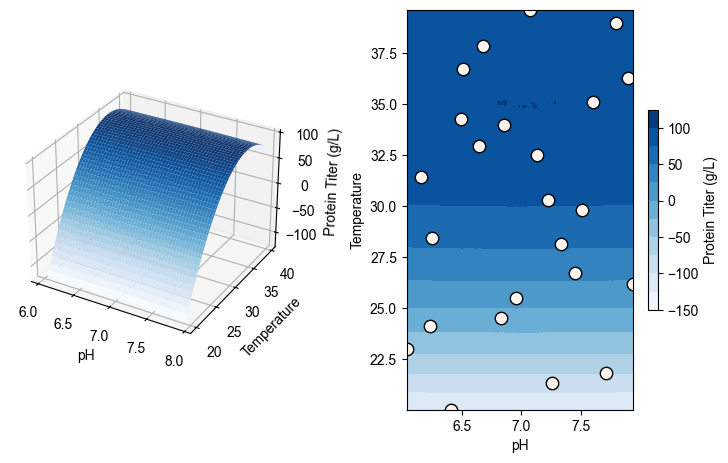

In [150]:
fig = plot_protein_production(train_X, train_Y, pH_opt, temp_opt, a, b, c, iterations, starting_replicates, replicate_list)

In [141]:
fig_1 = plot_protein_production(train_X_list[0], train_Y_list[0], pH_opt, temp_opt, a, b, c, iterations, starting_replicates,replicate_list)

NameError: name 'train_X_list' is not defined

Lengthscale: [[1.6113575e+04 5.9522879e-01]]
Noise: [0.00935322]
Mean: -1.011914
Predictive mean: tensor([-1.0119, -1.0119, -1.0119, -1.0119, -1.0119], dtype=torch.float64)
Predictive stddev: tensor([1.2234, 1.2234, 1.2234, 1.2234, 1.2234], dtype=torch.float64)


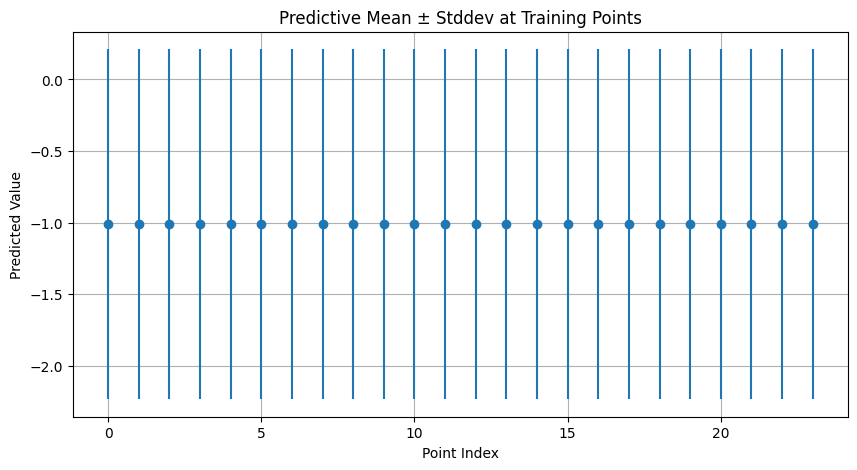

In [144]:
print("Lengthscale:", model_prior.covar_module.base_kernel.lengthscale.detach().numpy())
print("Noise:", model_prior.likelihood.noise.detach().numpy())
print("Mean:", model_prior.mean_module.constant.detach().numpy())
'''
print("Raw lengthscale:", model.covar_module.raw_lengthscale)
print("Raw noise:", model.likelihood.raw_noise)
print("Raw mean constant:", model.mean_module.raw_constant)
'''
model_prior.eval()
with torch.no_grad():
    posterior = model_prior(train_X)  # or some test_X
    mean = posterior.mean
    stddev = posterior.variance.sqrt()  # standard deviation (uncertainty)

print("Predictive mean:", mean[:5].squeeze())
print("Predictive stddev:", stddev[:5].squeeze())

plt.figure(figsize=(10, 5))
plt.errorbar(range(len(mean)), mean.squeeze(), yerr=stddev.squeeze(), fmt='o')
plt.title("Predictive Mean ± Stddev at Training Points")
plt.xlabel("Point Index")
plt.ylabel("Predicted Value")
plt.grid(True)
plt.show()


In [135]:
lengthscales = model_prior.covar_module.base_kernel.lengthscale.detach().numpy()
print("Lengthscales (ARD):", lengthscales)

for i, ls in enumerate(lengthscales.squeeze()):
    print(f"Lengthscale dim {i}: {ls:.4f}")

outputscale = model_prior.covar_module.outputscale.detach().numpy()
print("Outputscale:", outputscale)

Lengthscales (ARD): [[1.6113575e+04 5.9522879e-01]]
Lengthscale dim 0: 16113.5752
Lengthscale dim 1: 0.5952
Outputscale: 1.4966396


In [136]:
#Final clean version, above are tests and checks

print("\n=== GP Model Parameters ===")
print("Mean:", model_prior.mean_module.constant.item())
print("Noise (learned):", model_prior.likelihood.noise.item())
print("Outputscale:", model_prior.covar_module.outputscale.item())

lengthscales = model_prior.covar_module.base_kernel.lengthscale.detach().squeeze()
print("Lengthscales (ARD):", lengthscales.numpy())
for i, ls in enumerate(lengthscales):
    print(f"  Dim {i+1} lengthscale: {ls:.4f}")


=== GP Model Parameters ===
Mean: -1.0119140148162842
Noise (learned): 0.009353224089784088
Outputscale: 1.496639609336853
Lengthscales (ARD): [1.6113575e+04 5.9522879e-01]
  Dim 1 lengthscale: 16113.5752
  Dim 2 lengthscale: 0.5952
